# Project Overview  

This project consists of four CNN models for fashion image classification:  

1. **Primary Category Model** – Classifies images into three main categories:  
   - Glasses/Sunglasses  
   - Trousers/Jeans  
   - Shoes  

2. **Eyewear Model** – Distinguishes between:  
   - Glasses  
   - Sunglasses  

3. **Trousers Model** – Classifies trousers and jeans by gender:  
   - Trousers Male   
   - Jeans Male
   - Trousers Female  
   - Jeans Female 

4. **Footwear Model** – Classifies different types of shoes:  
   - Boots 
   - Trainers/Sneakers 
   - Sandals/Slippers  
   - Formal Shoes   
   - Others   

Each model is trained separately on its respective subset of the dataset to improve classification accuracy.


# Import Relevant Libraries  
Importing all the necessary libraries used for data processing, model building, and evaluation in this CNN project.


In [3]:
import numpy as np 
import pandas as pd 
import tensorflow as tf 
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn import metrics 
import itertools 
import datetime
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load the Dataset  
Loading the preprocessed dataset from `.npz` files and splitting it into training, validation, and testing sets.


In [5]:
data_train = np.load("Dataset/pants/Trousers & Jeans - All - Train.npz")
data_val = np.load("Dataset/pants/Trousers & Jeans - All - Validation.npz")
data_test = np.load("Dataset/pants/Trousers & Jeans - All - Test.npz")


In [6]:
print(f" Train shpe: {np.shape(data_train["images"])}")
print(f" Validation shpe: {np.shape(data_val["images"])}")
print(f" Test shpe: {np.shape(data_test["images"])}")


 Train shpe: (4004, 120, 90, 3)
 Validation shpe: (500, 120, 90, 3)
 Test shpe: (500, 120, 90, 3)


# Extract Images and Labels  
Extracting image data and corresponding labels from the training, validation, and testing datasets.


In [8]:
images_train = data_train["images"]
labels_train = data_train["labels"]


images_val = data_val["images"]
labels_val = data_val["labels"]


images_test = data_test["images"]
labels_test = data_test["labels"]

# Normalize Image Data  
Normalizing pixel values to the range [0, 1] to improve model training stability and performance.


In [10]:
images_train = images_train / 255.0
images_val = images_val / 255.0
images_test = images_test / 255.0


# Data Augmentation for Trousers Model  

Applying data augmentation to the training dataset to increase diversity and improve model generalization.  
- **Techniques used:**  
  - Random rotation up to 20 degrees  
  - Horizontal and vertical shifts up to 10%  
  - Random zoom up to 20%  
  - Horizontal flip  
- The augmented images are generated in equal number to the original training set and then combined, effectively doubling the size of the training data.


In [12]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,        
    width_shift_range=0.1,    
    height_shift_range=0.1,  
    zoom_range=0.2,           
    horizontal_flip=True,     
    fill_mode='nearest',  
)

num_augmented = len(images_train)

augmented_images = []
augmented_labels = []

aug_gen = datagen.flow(images_train, labels_train, batch_size=1, shuffle=False)

for i in range(num_augmented):
    img, label = next(aug_gen)
    augmented_images.append(img[0])    
    augmented_labels.append(label[0])  

augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)

# combine with original dataset
final_train_images = np.concatenate([images_train, augmented_images])
final_train_labels = np.concatenate([labels_train, augmented_labels])

# Build and Compile the Trousers Model  

Defining a CNN model for classifying trousers and jeans by gender (4 classes).  
- The architecture includes two convolutional and max-pooling layers, followed by a flattening layer and two dense layers (one hidden layer with 1024 units and the output layer).  
- **L2 regularization** is applied on all layers to reduce overfitting.  
- The model is compiled using the **Adam** optimizer and **SparseCategoricalCrossentr**


In [14]:
num_epochs = 15 
batch_size = 64 


model_pants = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64 , 5, input_shape = (120,90,3) , kernel_regularizer = tf.keras.regularizers.L2(0.0001)),
    tf.keras.layers.MaxPool2D(pool_size = (2,2) , strides = 2),

    tf.keras.layers.Conv2D(32 , 3 , kernel_regularizer = tf.keras.regularizers.L2(0.0001)),
    tf.keras.layers.MaxPool2D(pool_size = (2,2) , strides = 2),

    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(1024 , activation ="relu", kernel_regularizer = tf.keras.regularizers.L2(0.0001)),
    tf.keras.layers.Dense(4)
        
])


loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits= True , name = "sparse_categorical_crossentropy")
model_pants.compile(optimizer = "adam" , loss = loss_fn , metrics = ["accuracy" , "sparse_categorical_crossentropy"])

C:\Users\rasol\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# Define Callbacks and TensorBoard

Setting up training callbacks for the Trousers CNN model:  
- **EarlyStopping** monitors the validation sparse categorical cross-entropy and stops training if it does not improve for 2 consecutive epochs, helping to prevent overfitting.  
- **TensorBoard** is configured to log training metrics for real-time visualization, with logs stored in a timestamp


In [16]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience = 2 , monitor= "val_sparse_categorical_crossentropy")

log_dir = "logs//fit//pants//" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir , histogram_freq = 1)

# Train the Model  

Training the CNN model on the augmented training dataset to classify trousers and jeans by gender.  

In [18]:
model_pants.fit(final_train_images,final_train_labels,
          validation_data = (images_val , labels_val),
          epochs=num_epochs,
          batch_size = batch_size ,
          callbacks = [tensorboard_callback , early_stopping],
          shuffle = True
         )    

Epoch 1/15
126/126 ━━━━━━━━━━━━━━━━━━━━ 51s 397ms/step - accuracy: 0.3341 - loss: 5.4182 - sparse_categorical_crossentropy: 5.8943 - val_accuracy: 0.5420 - val_loss: 1.3410 - val_sparse_categorical_crossentropy: 3.2446
Epoch 2/15
126/126 ━━━━━━━━━━━━━━━━━━━━ 44s 352ms/step - accuracy: 0.5266 - loss: 1.3144 - sparse_categorical_crossentropy: 3.0318 - val_accuracy: 0.5980 - val_loss: 1.1778 - val_sparse_categorical_crossentropy: 3.0704
Epoch 3/15
126/126 ━━━━━━━━━━━━━━━━━━━━ 44s 350ms/step - accuracy: 0.5606 - loss: 1.2201 - sparse_categorical_crossentropy: 3.6528 - val_accuracy: 0.6140 - val_loss: 1.0999 - val_sparse_categorical_crossentropy: 3.0719
Epoch 4/15
126/126 ━━━━━━━━━━━━━━━━━━━━ 45s 358ms/step - accuracy: 0.5858 - loss: 1.1384 - sparse_categorical_crossentropy: 3.5455 - val_accuracy: 0.6340 - val_loss: 1.0261 - val_sparse_categorical_crossentropy: 3.1112


# Evaluate the Model  
Evaluating the trained CNN model on the test dataset to measure its final performance.  
The overall test accuracy is printed to summarize the model’s generalization capability.

In [20]:
_, model_pants_accuracy , model_pants_crossentropy = model_pants.evaluate(images_test , labels_test)
print(f"The model accuracy on test data is {model_pants_accuracy}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.6430 - loss: 0.9744 - sparse_categorical_crossentropy: 2.9935
The model accuracy on test data is 0.6460000276565552


# Make Predictions  
Generating predictions on the test dataset.  

In [22]:
predictions = model_pants.predict(images_test)
probabilities = tf.nn.softmax(predictions).numpy()*100
predictions_class = np.argmax(predictions , axis = 1)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


# Confusion Matrix and Classification Report  

Computing and visualizing the confusion matrix to evaluate the model’s performance across all classes.  
- The `plot_confusion_matrix` function displays the confusion matrix with optional normalization.  
- `classification_report` from scikit-learn provides precision, recall, and F1-score for each class.  
  1. Trousers Male  
  2. Jeans Male  
  3. Trousers Female
  4. Jeans Female


In [24]:
# confusion matrix function
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

              precision    recall  f1-score   support

           0       0.62      0.65      0.63       132
           1       0.79      0.62      0.69       143
           2       0.62      0.52      0.57       111
           3       0.59      0.80      0.68       114

    accuracy                           0.65       500
   macro avg       0.65      0.65      0.64       500
weighted avg       0.66      0.65      0.64       500

Confusion matrix, without normalization
[[86 16 17 13]
 [31 88  3 21]
 [20  3 58 30]
 [ 2  5 16 91]]


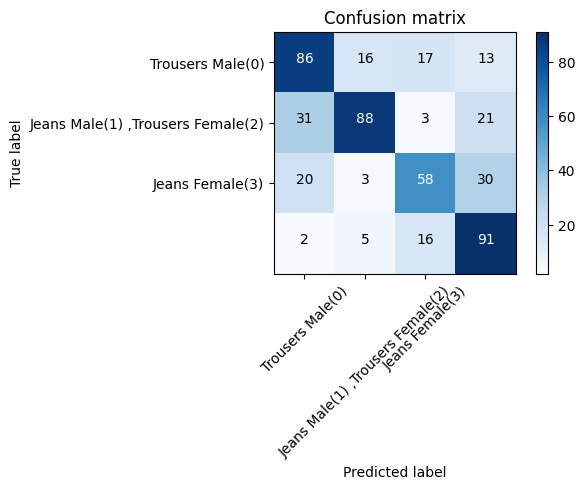

In [25]:
# Compute confusion matrix
cnf_matrix = metrics.confusion_matrix(labels_test, predictions_class, labels=[0,1,2,3])
np.set_printoptions(precision=2)

print (metrics.classification_report(labels_test, predictions_class))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Trousers Male(0)','Jeans Male(1) ,Trousers Female(2)','Jeans Female(3)'],normalize= False,  title='Confusion matrix')